## Imports

In [1]:
import numpy as np 
import pandas as pd 
import os
import gc
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.resnet50 import preprocess_input, decode_predictions

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


## Set Data path

In [2]:
datadir = os.path.expanduser('~/Dev/humpbackwhale/data')
pretrainedmodeldir = os.path.expanduser('~/Dev/humpbackwhale/pretrainedmodels')
os.listdir(os.path.expanduser(datadir))

['.DS_Store',
 'test',
 'data.zip',
 'trainexcel.csv',
 'train',
 'train.csv',
 'sample_submission.csv']

In [3]:
train_df = pd.read_csv(datadir + '/train.csv')
#train_df = train_df[:500]
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [4]:
def prepareImages(data, m, dataset):
    print("Preparing images")
    X_train = np.zeros((m, 100, 100, 3))
    count = 0
    
    for fig in data['Image']:
        #load images into images of size 100x100x3
        img = image.load_img(datadir+"/"+dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x.astype('float32')/255
        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return X_train

In [5]:
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

In [6]:
X = prepareImages(train_df, train_df.shape[0], "train")
#X /= 100
X.shape

Preparing images
('Processing image: ', 1, ', ', '0000e88ab.jpg')
('Processing image: ', 501, ', ', '04c72257b.jpg')
('Processing image: ', 1001, ', ', '09cacb84d.jpg')
('Processing image: ', 1501, ', ', '0ef961892.jpg')
('Processing image: ', 2001, ', ', '141b56a1a.jpg')
('Processing image: ', 2501, ', ', '199a417aa.jpg')
('Processing image: ', 3001, ', ', '1ec170983.jpg')
('Processing image: ', 3501, ', ', '23f084b93.jpg')
('Processing image: ', 4001, ', ', '29163ad0b.jpg')
('Processing image: ', 4501, ', ', '2e0fab120.jpg')
('Processing image: ', 5001, ', ', '3347515d9.jpg')
('Processing image: ', 5501, ', ', '3842d71dc.jpg')
('Processing image: ', 6001, ', ', '3d7f4c7d5.jpg')
('Processing image: ', 6501, ', ', '425f763ca.jpg')
('Processing image: ', 7001, ', ', '4714400cd.jpg')
('Processing image: ', 7501, ', ', '4c082fbdf.jpg')
('Processing image: ', 8001, ', ', '50c683e23.jpg')
('Processing image: ', 8501, ', ', '560d986ad.jpg')
('Processing image: ', 9001, ', ', '5b68c83ed.jpg')

(25361, 100, 100, 3)

In [7]:
y, label_encoder = prepare_labels(train_df['Id'])


/Users/marcelschneider/anaconda3/envs/humpbackwhale/lib/python2.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
y.shape

(25361, 5005)

In [9]:
def CNN_Simple(): 
    model = Sequential()

    model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

    model.add(BatchNormalization(axis = 3, name = 'bn0'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), name='max_pool'))
    model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
    model.add(Activation('relu'))
    model.add(AveragePooling2D((3, 3), name='avg_pool'))

    model.add(Flatten())
    model.add(Dense(500, activation="relu", name='rl'))
    model.add(Dropout(0.8))
    model.add(Dense(y.shape[1], activation='softmax', name='sm'))

    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    model.summary()
    
    return model

### Transfer Learning

In [10]:
bottleneck_features = np.load(pretrainedmodeldir+"/DogResnet50Data.npz")
train_Resnet50 = bottleneck_features['train']
test_Resnet50 = bottleneck_features['test']

def resnet_model(trainbottleneckfeatures):
    model = Sequential()
    
    model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

    model.add(GlobalAveragePooling2D(input_shape=trainbottleneckfeatures.shape[1:]))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y.shape[1], activation='softmax', name='sm'))
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    model.summary()
    
    return model

In [11]:
print(train_Resnet50.shape[1:])
print(X.shape)
#model = resnet_model(train_Resnet50)
model = CNN_Simple()
history = model.fit(X, y, epochs=100, batch_size=100, verbose=1)
gc.collect()

(1, 1, 2048)
(25361, 100, 100, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 94, 94, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 94, 94, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 47, 47, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 45, 45, 64)        0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 15, 15

25361/25361 [==============================] - 222s 9ms/step - loss: 0.7635 - acc: 0.8054
Epoch 63/100
25361/25361 [==============================] - 222s 9ms/step - loss: 0.7409 - acc: 0.8095
Epoch 64/100
25361/25361 [==============================] - 223s 9ms/step - loss: 0.7355 - acc: 0.8129
Epoch 65/100
25361/25361 [==============================] - 223s 9ms/step - loss: 0.7190 - acc: 0.8162
Epoch 66/100
25361/25361 [==============================] - 222s 9ms/step - loss: 0.6776 - acc: 0.8261
Epoch 67/100
25361/25361 [==============================] - 222s 9ms/step - loss: 0.6803 - acc: 0.8253
Epoch 68/100
25361/25361 [==============================] - 222s 9ms/step - loss: 0.6794 - acc: 0.8254
Epoch 69/100
25361/25361 [==============================] - 222s 9ms/step - loss: 0.6527 - acc: 0.8286
Epoch 70/100
25361/25361 [==============================] - 223s 9ms/step - loss: 0.6538 - acc: 0.8293
Epoch 71/100
25361/25361 [==============================] - 223s 9ms/step - loss: 0.63

300

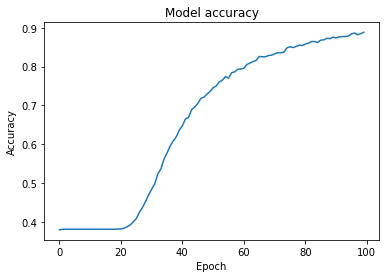

In [12]:
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [13]:
predictions = model.predict(np.array(X), verbose=1)


25361/25361 [==============================] - 98s 4ms/step


In [15]:
pred_df = copy.copy(train_df)
for i, pred in enumerate(predictions):
    pred_df.loc[i, 'Id'] = label_encoder.inverse_transform(pred.argsort()[-5:][::-1])

In [16]:
print(pred_df.head(10))


           Image                                                 Id
0  0000e88ab.jpg  [w_f48451c, new_whale, w_1f0cf0a, w_8da30ad, w...
1  0001f9222.jpg  [w_c3d896a, new_whale, w_cbb15d2, w_53215c6, w...
2  00029d126.jpg  [w_20df2c5, new_whale, w_f61b957, w_2b069ba, w...
3  00050a15a.jpg  [new_whale, w_4690940, w_4bf625b, w_f0fe284, w...
4  0005c1ef8.jpg  [new_whale, w_564a34b, w_d24c654, w_3de579a, w...
5  0006e997e.jpg  [new_whale, w_2365d55, w_8b86b95, w_c01c1f4, w...
6  000a6daec.jpg  [w_dd88965, new_whale, w_d405854, w_2745292, w...
7  000f0f2bf.jpg  [new_whale, w_6afdf63, w_b403feb, w_cd4cb49, w...
8  0016b897a.jpg  [w_64404ac, new_whale, w_8a1b71c, w_d573a68, w...
9  001c1ac5f.jpg  [w_a6f9d33, new_whale, w_343f088, w_3de579a, w...


### Evaluation of Prediction Precision

In [27]:
class myarray(np.ndarray):
    def __new__(cls, *args, **kwargs):
        return np.array(*args, **kwargs).view(myarray)
    def index(self, value):
        return np.where(self == value)

    
def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """   
    score = 0.0
    try:
        if not len(np.where(predictions == label)[0])==0:
            score =  1.0/(float(np.where(predictions == label)[0]) + 1)
            return score
        else:
            return 0.
            
    except ValueError:
        return 0.0

def map_per_set(labels, predictions):
    """Computes the average over multiple images.

    Parameters
    ----------
    labels : list
             A list of the true labels. (Only one true label per images allowed!)
    predictions : list of list
             A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """
    return np.mean([map_per_image(l, p) for l,p in zip(labels, predictions)])


In [29]:
totalaccuracy = 0.
totalaccuracy = map_per_set(train_df['Id'],pred_df['Id'])

In [30]:
print(totalaccuracy)

0.998130331349


### Create submission.csv (not in use for Udacity Capstone project, but created anyway)

In [32]:
pred_df.to_csv('submission.csv', index=False)